# S3 Data Download into Lepton Local Storage

This notebook shows how data can be downloaded from an external S3 bucket to mounted storage on a DGX Cloud Lepton dev pod. It makes use of a publicly available dataset for global fishery statistics purely as an example of loading a CSV dataset into a pandas DataFrame. The intent is for developers to make use of their own S3 buckets for transferring data to and from the dev pod.

<div class="alert alert-block alert-info">
<b>Note:</b> The license and terms of use for this sample dataset can be found <a href=https://registry.opendata.aws/sau-global-fisheries-catch-data/>here</a>.
</div>

### Requirements

-  Image: A Rapids Notebook container image such as `nvcr.io/nvidia/rapidsai/notebooks:25.08-cuda12.9-py3.13` or later
-  Packages: s3fs Python package installed
-  GPU: An NVIDIA Ampere or greater class GPU for cuDF acceleration (for example, A100)

### Storage Mount Setup

Follow the instructions __[here](https://docs.nvidia.com/dgx-cloud/lepton/features/storage/)__ to setup either Node Local or Static NFS volumes in DGX Cloud Lepton. Mount the storage point at `/mnt/data` with UID/GID of 1001 for the prescribed Rapids container image.

### Install s3fs

Make sure that we have the __[s3fs](https://s3fs.readthedocs.io/en/latest/)__ pip package installed.

In [1]:
!pip install s3fs

### Import pandas (Optionally with cuDF GPU Acceleration)

If we want to run the GPU accelerated version of __[pandas](https://pandas.pydata.org/docs/index.html)__, we can load the __[cuDF](https://docs.rapids.ai/api/cudf/stable/)__ extension.

In [2]:
%load_ext cudf.pandas

Import pandas in its own cell to make sure the previous load extension step was completed by the kernel.

In [3]:
import pandas as pd

### Anonymous S3 Access

Import the s3fs package and then as an example load a publicly available S3 dataset for yearly fishery statistics from around the globe. No credentials, access keys, secrets, or account are required in this case (anonymous access).

In [4]:
import s3fs

In [5]:
local_path = '/tmp/rfmo_12.csv'
bucket_path = 's3://fisheries-catch-data/global-catch-data/csv/rfmo_12.csv'
s3 = s3fs.S3FileSystem(anon=True)

### Options for Connecting to S3

If you need to access a private S3 bucket then there are keyword arguments for the key and secret to be applied.

In [6]:
# s3 = s3fs.S3FileSystem(
#      key='YOUR_ACCESS_KEY...',
#      secret='YOUR_ACCESS_SECRET...'
#    )

s3fs can also detect and use appropriate environment variables if they have been set for the key and secret.

In [7]:
# export FSSPEC_S3_KEY='YOUR_ACCESS_KEY...'
# export FSSPEC_S3_SECRET='YOUR_ACCESS_SECRET...'
# s3 = s3fs.S3FileSystem()

Credentials can also be detected and used by the underlying boto credential helper from client_kwargs, environment variables, config files, or an EC2 IAM server.

In [8]:
# s3 = s3fs.S3FileSystem(anon=False)

Finally, s3fs is compatible with non-AWS object storage such as MinIO. In this case, we would specify the URL of the MinIO endpoint.

In [9]:
# s3 = s3fs.S3FileSystem(
#      endpoint_url='https://non.aws.such.as.minio...'
#   )

### Download a Dataset from S3

In [10]:
s3.download(bucket_path, local_path)

[None]

Perform a cursory check that we have download the dataset.

In [11]:
!ls -lh /tmp/*.csv

-rw-r--r-- 1 rapids conda 194M Oct  6 19:39 /tmp/rfmo_12.csv


### Load the Dataset into a pandas DataFrame

Read the downloaded CSV file into a pandas DataFrame.

In [12]:
df = pd.read_csv(local_path)

### Work with the DataFrame

Check the number of rows in the DataFrame.

In [13]:
len(df)

1084102

In [14]:
df.dtypes

rfmo_id              int64
rfmo_name           object
layer_name          object
year                object
scientific_name     object
common_name         object
functional_group    object
commercial_group    object
fishing_entity      object
sector_type         object
catch_status        object
reporting_status    object
gear_name           object
catch_sum           object
real_value          object
dtype: object

Generally describe the original dataset.

In [15]:
df.describe(include='object')

,rfmo_name,layer_name,year,scientific_name,common_name,functional_group,commercial_group,fishing_entity,sector_type,catch_status,reporting_status,gear_name,catch_sum,real_value
count,1084102,1084102,1084102,1084102,1084102,1084102,1084102,1084102,1084102,1084102,1084102,1084102,1084102,1084102
unique,1,1,69,641,637,30,12,60,4,2,2,38,701429,788223
top,NEAFC,rfmo,2018,Gadus morhua,Atlantic cod,Medium demersals (30 - 89 cm),Cod-likes,Spain,Industrial,Landings,Reported,bottom trawl,0.0000000000,1e-06
freq,1084102,1084102,29574,37697,37697,127300,208364,179814,611992,952430,667785,167896,2772,205


Look at the first 5 rows of the DataFrame.

In [16]:
df.head()

,rfmo_id,rfmo_name,layer_name,year,scientific_name,common_name,functional_group,commercial_group,fishing_entity,sector_type,catch_status,reporting_status,gear_name,catch_sum,real_value
0,12,NEAFC,rfmo,1950,Marine fishes not identified,Marine fishes nei,Medium demersals (30 - 89 cm),Other fishes & inverts,Belgium,Industrial,Discards,Unreported,bottom trawl,1082.9153580534,1587553.9149062468
1,12,NEAFC,rfmo,1950,Marine fishes not identified,Marine fishes nei,Medium demersals (30 - 89 cm),Other fishes & inverts,Belgium,Industrial,Discards,Unreported,shrimp trawl,112.0446831571,164257.50550826537
2,12,NEAFC,rfmo,1950,Marine fishes not identified,Marine fishes nei,Medium demersals (30 - 89 cm),Other fishes & inverts,Belgium,Industrial,Discards,Unreported,beam trawl,1937.0042833652,2839648.2794133592
3,12,NEAFC,rfmo,1950,Marine fishes not identified,Marine fishes nei,Medium demersals (30 - 89 cm),Other fishes & inverts,Belgium,Industrial,Discards,Unreported,otter trawl,103.1146899565,151166.1354762795
4,12,NEAFC,rfmo,1950,Marine fishes not identified,Marine fishes nei,Medium demersals (30 - 89 cm),Other fishes & inverts,Belgium,Industrial,Discards,Unreported,pelagic trawl,0.6578542548,964.4143375576564


Look at the last 5 rows of the DataFrame.

In [17]:
df.tail()

,rfmo_id,rfmo_name,layer_name,year,scientific_name,common_name,functional_group,commercial_group,fishing_entity,sector_type,catch_status,reporting_status,gear_name,catch_sum,real_value
1084097,12,NEAFC,rfmo,2018,Donax trunculus,Truncate donax,Other demersal invertebrates,Molluscs,Spain,Artisanal,Landings,Reported,artisanal fishing gear,0.0123567702,0.3617893716732997
1084098,12,NEAFC,rfmo,2018,Nassarius mutabilis,Changeable nassa,Other demersal invertebrates,Molluscs,Spain,Artisanal,Discards,Unreported,artisanal fishing gear,0.0000932092,0.1366446650898646
1084099,12,NEAFC,rfmo,2018,Nassarius mutabilis,Changeable nassa,Other demersal invertebrates,Molluscs,Spain,Artisanal,Landings,Reported,artisanal fishing gear,0.0021910469,0.016375757448037924
1084100,12,NEAFC,rfmo,2018,Nassarius mutabilis,Changeable nassa,Other demersal invertebrates,Molluscs,Spain,Artisanal,Landings,Reported,artisanal fishing gear,0.0000010966,4.1021395389478396e-09
1084101,12,NEAFC,rfmo,2018,Nassarius mutabilis,Changeable nassa,Other demersal invertebrates,Molluscs,Spain,Artisanal,Landings,Reported,artisanal fishing gear,0.0000010966,4.1021395389478396e-09


Count the top 15 different instances of fishing gear in the dataset. Profile the GPU usage (which may be minimal).

In [18]:
%%cudf.pandas.profile
df["gear_name"].value_counts().head(15)

gear_name
bottom trawl                 167896
small scale gillnets         116035
unknown class                106609
small scale pots or traps     83572
purse seine                   79387
small scale lines             68955
longline                      43772
gillnet                       42023
artisanal fishing gear        39466
other                         36284
small scale seine nets        30715
shrimp trawl                  29150
mixed gear                    26055
small scale other nets        25718
dredge                        24861
Name: count, dtype: int64

                                                                                                                
                                           Total time elapsed: 0.287 seconds                                    
                                         4 GPU function calls in 0.039 seconds                                  
                                         1 CPU function calls in 0.002 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DataFrame.__getitem__      │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ IndexOpsMixin.value_counts │ 1          │ 0.032       │ 0.032       │ 0          │ 0.000       │ 0.000       │
│ NDFrame.head               │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series.__repr__            │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ NDFrame._repr_latex_       │ 0          │ 0.000       │ 0.000       │ 1          │ 0.002       │ 0.002       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- NDFrame._repr_latex_

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=301923;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

Convert some of the columns from object to numeric or date types.

In [19]:
df['year'] = pd.to_datetime(df['year'])
df['catch_sum'] = pd.to_numeric(df['catch_sum'])
df['real_value'] = pd.to_numeric(df['real_value'])

Check the datatypes again.

In [20]:
df.dtypes

rfmo_id                      int64
rfmo_name                   object
layer_name                  object
year                datetime64[ns]
scientific_name             object
common_name                 object
functional_group            object
commercial_group            object
fishing_entity              object
sector_type                 object
catch_status                object
reporting_status            object
gear_name                   object
catch_sum                  float64
real_value                 float64
dtype: object

Collect the last 5 years of the dataset.

In [21]:
years = df['year'].unique()[-5:]

Create a new DataFrame from the top 15 countries in the dataset with the largest total catch in metric tonnes between 2014 and 2018.

In [22]:
top_fisheries_by_catch = df[(df['year'] >= years[0]) & (df['year'] <= years[4])].groupby(['fishing_entity'], as_index = False)[['catch_sum']].sum().copy().sort_values(by='catch_sum',ascending=False).head(15)

Plot the result as a horizontal bar chart.

In [23]:
import matplotlib.pyplot as plt

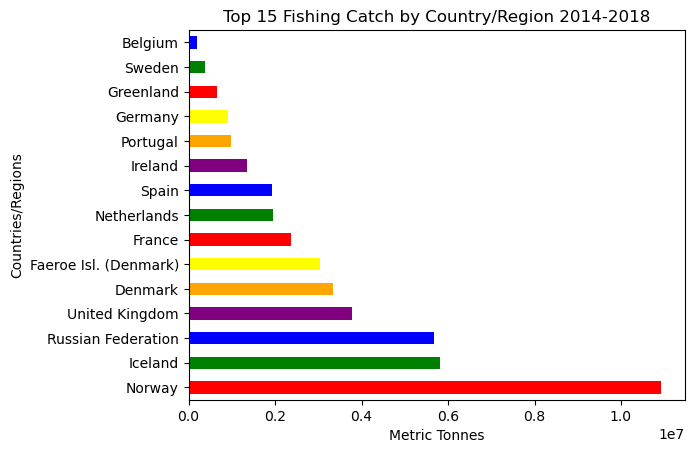

In [24]:
colors = ['red', 'green', 'blue', 'purple', 'orange','yellow']
top_fisheries_by_catch.plot(x='fishing_entity',y='catch_sum',kind='barh',color=colors,legend=False)
plt.title('Top 15 Fishing Catch by Country/Region 2014-2018')
plt.xlabel('Metric Tonnes')
plt.ylabel('Countries/Regions')
plt.show()

This completes the notebook example.